# Prepare some things
## Load some modules

In [1]:
from tensorflow.keras import models
from tensorflow.keras.datasets import mnist
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import sys
sys.path.append('../')
from models import get_autoencoder_model, get_dec_model, get_vae_model, get_clustering_vae_model, get_vade_models
from clustering_metrics import evaluate_model, evaluate_clustering

## Load the MNIST test dataset

In [3]:
(x_train, y_train), (x_test, y_test) = (mnist.load_data())
x_train = x_train.reshape(-1, 28*28).astype("float")/255
x_test = x_test.reshape(-1, 28*28).astype("float")/255

## Define some parameters

In [4]:
IMG_DIM = 28*28
LATENT_DIM = 10
INTERMEDIATE_DIMS = (512, 512, 2048)
N_CLUSTERS = 10

kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=30)
gmm = GaussianMixture(n_components=N_CLUSTERS, covariance_type='diag', n_init=10)

results = []

# Raw data

## K-means

['Acc: 0.592', 'ARI: 0.408', 'AMI: 0.527', 'Sil: 0.059']


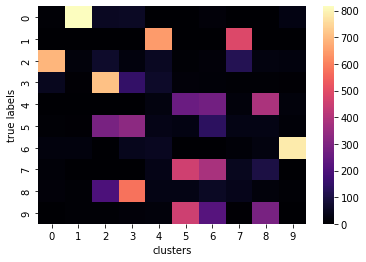

In [5]:
metrics = evaluate_clustering(x_test, y_test, kmeans.fit_predict(x_test))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_raw_kmeans = {'RL type': 'None (raw data)',
                      'Clustering algorithm': 'K-means'}
results_raw_kmeans.update(metrics)
results.append(results_raw_kmeans)

## GMM

['Acc: 0.440', 'ARI: 0.219', 'AMI: 0.337', 'Sil: 0.015']


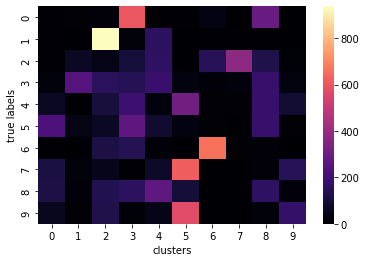

In [6]:
metrics = evaluate_clustering(x_test, y_test, gmm.fit_predict(x_test))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_raw_gmm = {'RL type': 'None (raw data)',
                   'Clustering algorithm': 'GMM'}
results_raw_gmm.update(metrics)
results.append(results_raw_gmm)

# PCA

In [7]:
# Find the number of PCs to explain 80% of the variance:
pca = PCA(n_components=0.8)
pca.fit(x_train)

PCA(n_components=0.8)

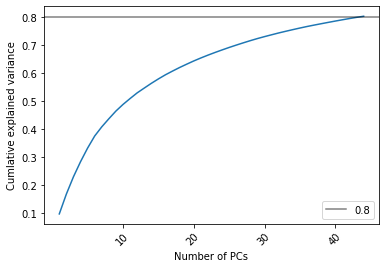

In [8]:
plt.plot(np.arange(0, pca.n_components_),np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y = 0.8, color='black', linestyle='-', alpha=0.5, label="0.8")
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Cumlative explained variance');
plt.legend();

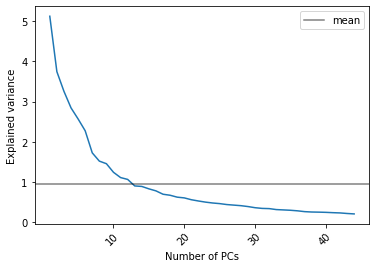

In [9]:
plt.plot(np.arange(0, pca.n_components_), pca.explained_variance_)
plt.axhline(y = np.mean(pca.explained_variance_), color='black', linestyle='-', alpha=0.5, label="mean")
plt.xticks(np.arange(9, pca.n_components_, 10), np.arange(10, pca.n_components_+1, 10), rotation=45, rotation_mode="anchor", ha='right')
plt.xlabel('Number of PCs')
plt.ylabel('Explained variance');
plt.legend();

In [10]:
pca.n_components_

44

We need 44 PCs to explain 80% of the variance.

In [11]:
x_test_pca = pca.transform(x_test)

## K-means

['Acc: 0.594', 'ARI: 0.408', 'AMI: 0.527', 'Sil: 0.088']


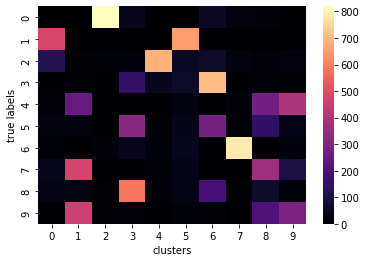

In [12]:
metrics = evaluate_clustering(x_test_pca, y_test, kmeans.fit_predict(x_test_pca))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_pca_kmeans = {'RL type': 'PCA',
                    'Clustering algorithm': 'K-Means'}
results_pca_kmeans.update(metrics)
results.append(results_pca_kmeans)

## GMM

['Acc: 0.472', 'ARI: 0.235', 'AMI: 0.428', 'Sil: 0.017']


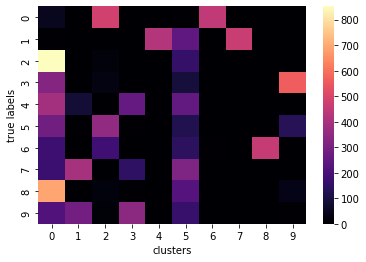

In [13]:
metrics = evaluate_clustering(x_test_pca, y_test, gmm.fit_predict(x_test_pca))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_pca_gmm = {'RL type': 'PCA',
                   'Clustering algorithm': 'GMM'}
results_pca_gmm.update(metrics)
results.append(results_pca_gmm)

# Autoencoder

In [14]:
model_ae = get_autoencoder_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_ae.load_weights("model_weights/dec/pretrained/ae")
z = model_ae.encode(x_test)

## K-means on embeddings

['Acc: 0.831', 'ARI: 0.687', 'AMI: 0.730', 'Sil: 0.189']


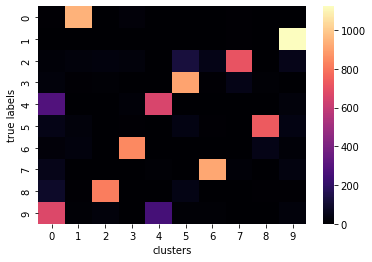

In [15]:
metrics = evaluate_clustering(z, y_test, kmeans.fit_predict(z))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_ae_kmeans = {'RL type': 'AE embeddings',
                     'Clustering algorithm': 'K-means'}
results_ae_kmeans.update(metrics)
results.append(results_ae_kmeans)

## GMM on embeddings

['Acc: 0.766', 'ARI: 0.571', 'AMI: 0.683', 'Sil: 0.145']


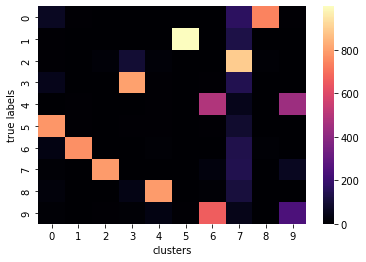

In [16]:
metrics = evaluate_clustering(z, y_test, gmm.fit_predict(z))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_ae_gmm = {'RL type': 'AE embeddings',
                  'Clustering algorithm': 'GMM'}
results_ae_gmm.update(metrics)
results.append(results_ae_gmm)

# DEC

## K-means

['Acc: 0.831', 'ARI: 0.690', 'AMI: 0.736', 'Sil: 0.925']


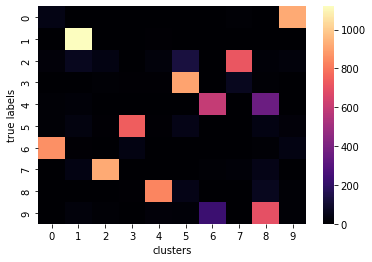

In [17]:
model_dec_kmeans = get_dec_model(model_ae.encoder, N_CLUSTERS)
model_dec_kmeans.load_weights("model_weights/dec/finetuned/dec_kmeans")

metrics = evaluate_model(x_test, y_test, model_dec_kmeans.classify, model_dec_kmeans.encode)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_dec_kmeans = {'RL type': 'DEC',
                      'Clustering algorithm': 'K-means'}
results_dec_kmeans.update(metrics)
results.append(results_dec_kmeans)

## GMM

['Acc: 0.763', 'ARI: 0.561', 'AMI: 0.687', 'Sil: 0.934']


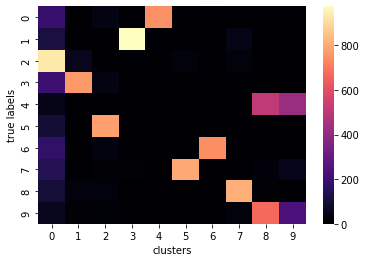

In [18]:
model_dec_gmm = get_dec_model(model_ae.encoder, N_CLUSTERS)
model_dec_gmm.load_weights("model_weights/dec/finetuned/dec_gmm")

metrics = evaluate_model(x_test, y_test, model_dec_gmm.classify, model_dec_gmm.encode)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_dec_gmm = {'RL type': 'DEC',
                   'Clustering algorithm': 'GMM'}
results_dec_gmm.update(metrics)
results.append(results_dec_gmm)

# VAE

In [19]:
model_vae = get_vae_model(IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vae.load_weights("model_weights/cvae/pretrained/vae")
z = model_vae.encode_only_mu(x_test)

## K-means on embeddings

['Acc: 0.592', 'ARI: 0.410', 'AMI: 0.541', 'Sil: 0.164']


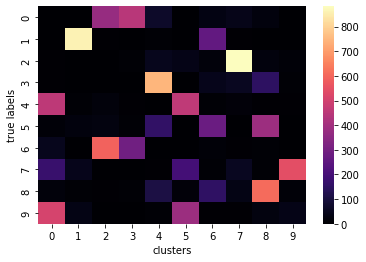

In [20]:
metrics = evaluate_clustering(z, y_test, kmeans.fit_predict(z))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_vae_kmeans = {'RL type': 'VAE embeddings',
                      'Clustering algorithm': 'K-means'}
results_vae_kmeans.update(metrics)
results.append(results_vae_kmeans)

## GMM on embeddings

['Acc: 0.485', 'ARI: 0.246', 'AMI: 0.394', 'Sil: -0.006']


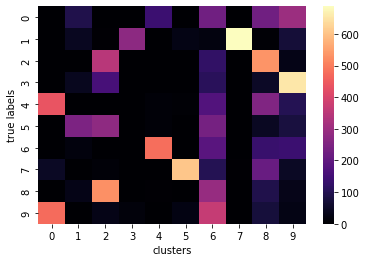

In [21]:
metrics = evaluate_clustering(z, y_test, gmm.fit_predict(z))
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_vae_gmm = {'RL type': 'VAE embeddings',
                   'Clustering algorithm': 'GMM'}
results_vae_gmm.update(metrics)
results.append(results_vae_gmm)

# Clustering VAE

## K-means

['Acc: 0.567', 'ARI: 0.371', 'AMI: 0.489', 'Sil: 0.200']


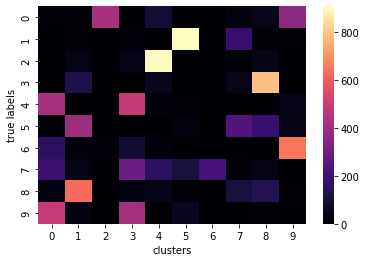

In [22]:
model_cvae_kmeans = get_clustering_vae_model(model_vae, N_CLUSTERS)
model_cvae_kmeans.load_weights("model_weights/cvae/finetuned/cvae_kmeans")

metrics = evaluate_model(x_test, y_test, model_cvae_kmeans.classify, model_cvae_kmeans.encode_only_mu)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_cvae_kmeans = {'RL type': 'Clustering VAE',
                       'Clustering algorithm': 'K-means'}
results_cvae_kmeans.update(metrics)
results.append(results_cvae_kmeans)

##  GMM

['Acc: 0.589', 'ARI: 0.357', 'AMI: 0.487', 'Sil: 0.124']


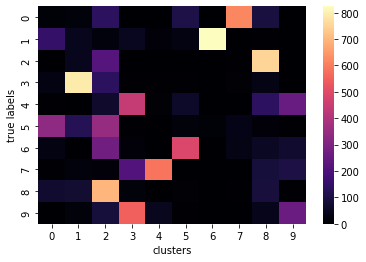

In [23]:
model_cvae_gmm = get_clustering_vae_model(model_vae, N_CLUSTERS)
model_cvae_gmm.load_weights("model_weights/cvae/finetuned/cvae_gmm")

metrics = evaluate_model(x_test, y_test, model_cvae_gmm.classify, model_cvae_gmm.encode_only_mu)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_cvae_gmm = {'RL type': 'Clustering VAE',
                    'Clustering algorithm': 'GMM'}
results_cvae_gmm.update(metrics)
results.append(results_cvae_gmm)

# VAE + DEC

## K-means

['Acc: 0.613', 'ARI: 0.422', 'AMI: 0.538', 'Sil: 0.904']


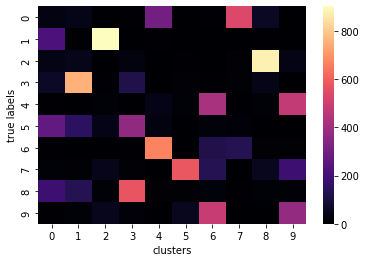

In [24]:
vae_dec_encoder = models.Model(model_vae.encoder.inputs, model_vae.encoder.outputs[0])
model_vae_dec_kmeans = get_dec_model(vae_dec_encoder, N_CLUSTERS)
model_vae_dec_kmeans.load_weights("model_weights/vae_dec/finetuned/dec_kmeans")

metrics = evaluate_model(x_test, y_test, model_vae_dec_kmeans.classify, model_vae_dec_kmeans.encode)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_vae_dec_kmeans = {'RL type': 'VAE-DEC',
                          'Clustering algorithm': 'K-Means'}
results_vae_dec_kmeans.update(metrics)
results.append(results_vae_dec_kmeans)

##  GMM

['Acc: 0.569', 'ARI: 0.313', 'AMI: 0.469', 'Sil: 0.867']


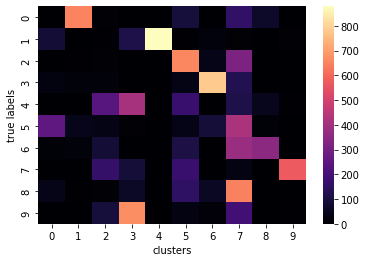

In [25]:
model_vae_dec_gmm = get_dec_model(vae_dec_encoder, N_CLUSTERS)
model_vae_dec_gmm.load_weights("model_weights/vae_dec/finetuned/dec_gmm")

metrics = evaluate_model(x_test, y_test, model_vae_dec_gmm.classify, model_vae_dec_gmm.encode)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_vae_dec_gmm = {'RL type': 'VAE-DEC',
                       'Clustering algorithm': 'GMM'}
results_vae_dec_gmm.update(metrics)
results.append(results_vae_dec_gmm)

# VaDE (GMM)

['Acc: 0.941', 'ARI: 0.877', 'AMI: 0.876', 'Sil: 0.226']


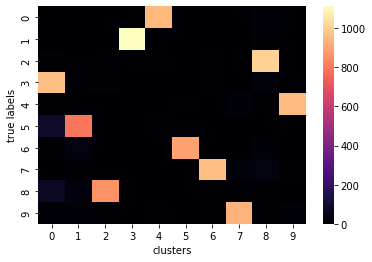

In [26]:
_, model_vade = get_vade_models(N_CLUSTERS, IMG_DIM, LATENT_DIM, INTERMEDIATE_DIMS)
model_vade.load_weights("model_weights/vade/finetuned/vade")

metrics = evaluate_model(x_test, y_test, model_vade.classify, model_vade.encode_only_mu)
print([f'{metric}: {value:.3f}' for metric, value in metrics.items()])

results_vade = {'RL type': 'VaDE',
                'Clustering algorithm': 'GMM'}
results_vade.update(metrics)
results.append(results_vade)

# Results summary

In [27]:
results = pd.DataFrame(results)

In [28]:
results.style.background_gradient(axis=0, cmap="cividis", text_color_threshold=0.3).format('{:.2f}', subset=['Acc','ARI','AMI','Sil'])

,RL type,Clustering algorithm,Acc,ARI,AMI,Sil
0,None (raw data),K-means,0.59,0.41,0.53,0.06
1,None (raw data),GMM,0.44,0.22,0.34,0.02
2,PCA,K-Means,0.59,0.41,0.53,0.09
3,PCA,GMM,0.47,0.23,0.43,0.02
4,AE embeddings,K-means,0.83,0.69,0.73,0.19
5,AE embeddings,GMM,0.77,0.57,0.68,0.14
6,DEC,K-means,0.83,0.69,0.74,0.93
7,DEC,GMM,0.76,0.56,0.69,0.93
8,VAE embeddings,K-means,0.59,0.41,0.54,0.16
9,VAE embeddings,GMM,0.48,0.25,0.39,-0.01


In [29]:
results.to_csv('results.csv', index=False)

In [ ]:
# Markdown-like table:
# !pip install tabulate
# from tabulate import tabulate
# print(tabulate(results.round(2), headers='keys', tablefmt='pipe', showindex=False))